In [36]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os, csv
import pandas as pd
import scipy.optimize as sp
import time

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import matplotlib as mpl
import matplotlib.cm as cm

%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/aux_funcs.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/RSRG_class.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/aux_funcs.py

In [52]:
#run_dir = "fresh_rerun/"
run_dir = "/home/guaravtenkila/Disorder_sims/Ising_RSRG/log_output/mag_scaling/"
log_file = pd.read_csv(run_dir + "log_file.csv")
ts_list = log_file['ts'].tolist()
log_file

,L,steps,a,b,w,n_runs,ts
0,8,63,0.1,0.105,5.0,1440,77385471850.01.0
1,8,63,0.1,0.105,5.2,1440,77386218852.01.0
2,8,63,0.1,0.105,5.4,1440,77386938854.01.0
3,8,63,0.1,0.105,5.6,1440,77387697856.000000000000011.0
4,8,63,0.1,0.105,5.8,1440,77388435858.000000000000011.0
...,...,...,...,...,...,...,...
132,32,1023,0.1,0.105,9.0,1440,967242943289.999999999999971.0
133,32,1023,0.1,0.105,9.2,1440,968307553291.999999999999961.0
134,32,1023,0.1,0.105,9.4,1440,969391443293.999999999999941.0
135,32,1023,0.1,0.105,9.6,1440,970471713295.999999999999941.0


In [3]:
def generate_corr_matrix(reverse_dict, L):
    vect = np.zeros(shape=(L*L, L*L), dtype=bool)
    for key in reverse_dict:
        if reverse_dict[key] is None: continue
        vect[key,reverse_dict[key]] = True
    return np.einsum('ab,ac->bc', vect, vect)

def generate_corr_matrix_alt(clust_dict, L):
    corr_mat_alt = np.zeros(shape=(L*L, L*L), dtype=bool)
    for i in range(L*L):
        for j in range(i, L*L):
            corr_mat_alt[i,j] = (clust_dict[i]==clust_dict[j])
    corr_mat_alt = corr_mat_alt.T + corr_mat_alt 
    return corr_mat_alt

def generate_corr_matrix_alt2(clust_dict, reverse_dict, L):
    #Fastest
    corr_mat = np.zeros(shape=(L*L, L*L), dtype=bool)
    for i in range(L*L):
        corr_mat[i, reverse_dict[clust_dict[i]]] = True
    return corr_mat

def power_law(x, scale, power):
    return 1/(1+x*scale)**power

def second_cumulant(X):
    return ((X-X.mean())**2).mean()

def fourth_cumulant(X):
    return ((X-X.mean())**4).mean() - 3*(((X-X.mean())**2).mean())**2

In [26]:
#L = 40
Lx, Ly = 40, 40 
rect_side = "(%d, %d)"%(Lx, Ly)
#fixed_length_slice = log_file[lambda df: (df['L'] == rect_side)]
fixed_length_slice = log_file[lambda df: (df['L'] == Lx)]
ts_list = fixed_length_slice['ts'].tolist()
w_vals = fixed_length_slice['w'].tolist()
n_runs_list = fixed_length_slice['n_runs'].tolist()
#print(ts_list)
mean_corr_mat_list = []

for index, ts in enumerate(ts_list):

    with open(run_dir+"LIsing_2D_cmat_"+str(ts)+".pkl", "rb") as fp:   
        c_mat = pickle.load(fp)
        
    mean_corr_mat_list.append(c_mat)
    

0.2969682084606867 0.033298545552071734 5.0
0.36537048818197493 0.029032467241642268 5.2
0.5820940656108788 0.02854665671998647 5.4
0.7128137044440646 0.025869099209704313 5.6
0.7669570351734059 0.020762682520518782 5.8
1.3995357209158812 0.03603284330950217 6.0
1.4497782365269778 0.027548048216202388 6.2
1.6342132669021459 0.02657976686269625 6.4
2.1172346655221665 0.036919176033015165 6.6
2.3577131278595895 0.04191583173012012 6.8
0.2848147172495125 0.03359381280909067 5.0
0.32538515258832396 0.027458201113504728 5.2
0.5534777516126568 0.028031026053717052 5.4
0.6066795938044833 0.02174226481817195 5.6
0.8597791095215447 0.02156010912055779 5.8
1.3589295447607925 0.03567404809684152 6.0
1.4607525298433899 0.029342325995534806 6.2
1.7700955793186226 0.031356905100876555 6.4
1.9327479224460278 0.03062078882484784 6.6
2.3556920182687406 0.040623160879286344 6.8


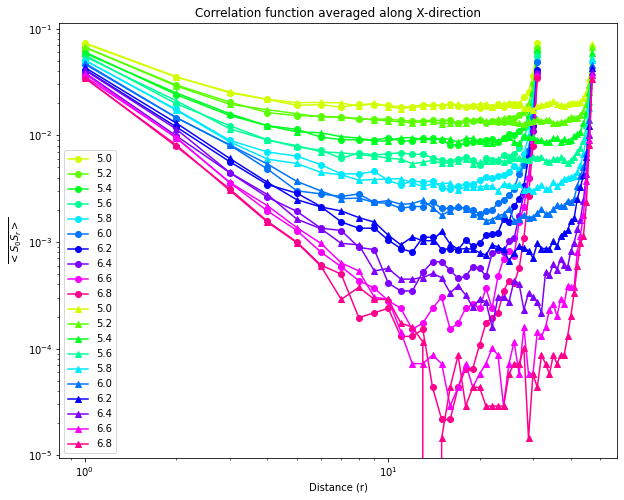

In [68]:
plt.figure(figsize=(10,8))
norm = mpl.colors.Normalize(vmin=4.5, vmax=7)
cmap = cm.hsv  #'viridis'#
m = cm.ScalarMappable(norm=norm, cmap=cmap)


for L in [32, 48]:

    #L = 40
    Lx, Ly = L, L 
    rect_side = "(%d, %d)"%(Lx, Ly)
    #fixed_length_slice = log_file[lambda df: (df['L'] == rect_side)]
    fixed_length_slice = log_file[lambda df: (df['L'] == Lx)]
    ts_list = fixed_length_slice['ts'].tolist()
    w_vals = fixed_length_slice['w'].tolist()
    n_runs_list = fixed_length_slice['n_runs'].tolist()
    #print(ts_list)
    mean_corr_mat_list = []

    for index, ts in enumerate(ts_list):

        with open(run_dir+"LIsing_2D_cmat_"+str(ts)+".pkl", "rb") as fp:   
            c_mat = pickle.load(fp)

        mean_corr_mat_list.append(c_mat)


    

    param_vals = []
    corr_exponent = []

    for index, w in enumerate(w_vals):
        w = round(w, 2)
        if not (w>4.5 and w<7.0): continue
        #if not index%2==0: continue
        #if not 9<index<20: continue
        mean_corr_mat = mean_corr_mat_list[index]
        y_vals = np.arange(Lx)
        corr_function = np.zeros(shape=(Lx))

        for y in range(Lx):

            #Corr function along vertical direction, averaged over vertical translationally invariant slices
            for x in range(Ly):
                corr_function[y] += mean_corr_mat[index_map_rect(0,x,Lx, Ly), index_map_rect(y,x,Lx, Ly)]


            #Corr function along the top boundary (Generally very noisy)
            #corr_function[y] = mean_corr_mat[index_map(0,0,L), index_map(0,y,L)]

            #Corr function averaged along the boundary direction
            #for x in range(L):
            #    corr_function[y]+=mean_corr_mat[index_map(x,0,L), index_map(x,y, L)]
        sum_acc = Lx
        x_data = y_vals[1:]
        y_data = corr_function[1:]/sum_acc
        #plt.scatter(y_vals, corr_function/L, label=str(w))
        if L ==32: m_type='o'
        elif L==48: m_type='^'
        else: m_type='s'
        c = m.cmap(norm(w))
        plt.plot(x_data, y_data,label=str(w), marker=m_type, color=c)
        popt, pcov = curve_fit(power_law_scale,  x_data[2:8],y_data[2:8] )

        #plt.plot(x_data, power_law_scale(x_data, *popt))
        print(*popt, w)
        #param_vals.append(w)
        #corr_exponent.append(popt[1])

plt.title("Correlation function averaged along X-direction")
plt.xlabel("Distance (r)")
plt.ylabel(r"$\overline{<S_0 S_r>}$")
plt.legend()
#plt.xlim(0, 20)
#plt.axhline(y=1/800/Lx)
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-3, 1e-1)
#plt.xlim(1, 16)
plt.savefig("Corr_funcs")

In [6]:
def lin_fit(x, m, b):
    return m*x + b

Text(0.5, 1.0, 'Exponent of power law fit to correlation function')

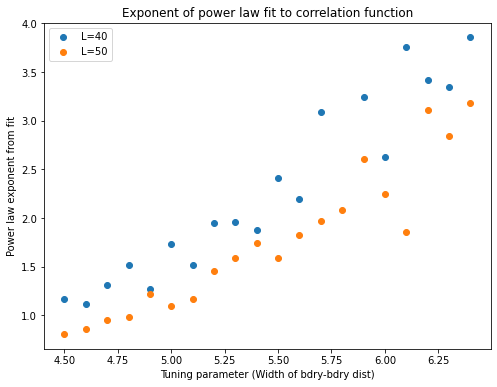

In [133]:
plt.figure(figsize=(8,6))

for L in [40, 50, 60]:
    fixed_length_slice = log_file[lambda df: (df['L'] == L)]
    ts_list = fixed_length_slice['ts'].tolist()
    w_vals = fixed_length_slice['w'].tolist()
    n_runs_list = fixed_length_slice['n_runs'].tolist()
    #print(ts_list)
    mean_corr_mat_list = []

    for index, ts in enumerate(ts_list):

        with open(run_dir+"LIsing_2D_cmat_"+str(ts)+".pkl", "rb") as fp:   
            c_mat = pickle.load(fp)

        mean_corr_mat_list.append(c_mat)
    
    param_vals = []
    corr_exponent = []

    for index, w in enumerate(w_vals):
        w = round(w, 2)
        if not index%1 ==0: continue
        mean_corr_mat = mean_corr_mat_list[index]
        y_vals = np.arange(L)
        corr_function = np.zeros(shape=(L))

        for y in range(L):
            
            #Corr function along vertical direction, averaged over vertical translationally invariant slices
            for x in range(L):
                corr_function[y] += mean_corr_mat[index_map(0,x,L), index_map(y,x,L)]
            
            ##Corr function along the top boundary (Generally very noisy)
            #corr_function[y] = mean_corr_mat[index_map(0,0,L), index_map(0,y,L)]
            """
            #Corr function averaged along the boundary direction
            for x in range(L):
                corr_function[y]+=mean_corr_mat[index_map(x,0,L), index_map(x,y, L)]
            """
        sum_acc = L
        x_data = y_vals[1:]
        y_data = corr_function[1:]/sum_acc

        popt, pcov = curve_fit(power_law_scale,  x_data[4:20],y_data[4:20] )

        param_vals.append(w)
        corr_exponent.append(popt[0])

    plt.scatter(param_vals, corr_exponent, label="L="+str(L))
    

plt.legend()
plt.xlabel("Tuning parameter (Width of bdry-bdry dist)")
plt.ylabel("Power law exponent from fit")
plt.title("Exponent of power law fit to correlation function")

In [9]:
#L_list = [40, 60, 80, 100, 120, 150]
c_dict = {150:'red', 120:'blue', 60:'green', 80:'cyan', 40:'orange', 100:'magenta', 50:'brown'}
L_list = [40, 50, 60]

w_vals_comp = []
corr_sum_comp = []

for L in L_list:
    #fixed_length_slice = log_file[lambda df: (df['L'] == '('+str(L)+', 20)')]
    #fixed_length_slice = log_file[lambda df: (df['L'] == L+1)]
    fixed_length_slice = log_file[lambda df: (df['L'] == L)]
    ts_list = fixed_length_slice['ts'].tolist()
    w_vals = fixed_length_slice['w'].tolist()
    corr_sum_avg = []

    for index, ts in enumerate(ts_list):
        with open(run_dir+"LIsing_2D_cmat_"+str(ts)+".pkl", "rb") as fp:   
            c_mat = pickle.load(fp)
        corr_sum_avg.append(c_mat.sum()/(L**4))
        
    w_vals_comp.append(w_vals)
    corr_sum_comp.append(corr_sum_avg)

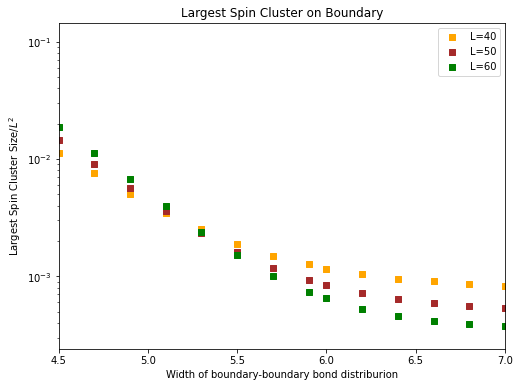

In [13]:
plt.figure(figsize=(8, 6))
for i, L in enumerate(L_list):
    plt.scatter(w_vals_comp[i], corr_sum_comp[i], c=c_dict[L], marker='s', label='L='+str(L), s=30)
    
plt.ylabel("Largest Spin Cluster Size/$L^2$")
plt.xlabel("Width of boundary-boundary bond distriburion")
plt.title("Largest Spin Cluster on Boundary")
plt.xlim(4.5, 7)
#plt.ylim(0, 0.1)
plt.yscale('log')
plt.legend()

In [9]:
#L_list = [40, 60, 80, 100, 120, 150]
c_dict = {150:'red', 120:'blue', 60:'green', 80:'cyan', 40:'orange', 100:'magenta', 50:'brown'}
L_list = [40, 50, 60]

w_vals_comp = []
order_param_comp = []
second_cum_comp = []
fourth_cum_comp = []


for L in L_list:
    #fixed_length_slice = log_file[lambda df: (df['L'] == '('+str(L)+', 20)')]
    #fixed_length_slice = log_file[lambda df: (df['L'] == L+1)]
    fixed_length_slice = log_file[lambda df: (df['L'] == L)]
    ts_list = fixed_length_slice['ts'].tolist()
    w_vals = fixed_length_slice['w'].tolist()
    order_param_avg = []
    second_cum = []
    fourth_cum = []

    for index, ts in enumerate(ts_list):
        with open(run_dir+"LIsingB_2D_rawcmat_"+str(ts)+".npz", "rb") as fp:   
            c_mat = np.load(fp)['arr_0']
        
        order_param = (c_mat.sum(axis=(1,2)))/L**4
        order_param_avg.append(order_param.mean())
        second_cum.append(second_cumulant(order_param))
        fourth_cum.append(fourth_cumulant(order_param))
        
    
    w_vals_comp.append(w_vals)
    order_param_comp.append(order_param_avg)
    second_cum_comp.append(second_cum)
    fourth_cum_comp.append(fourth_cum)

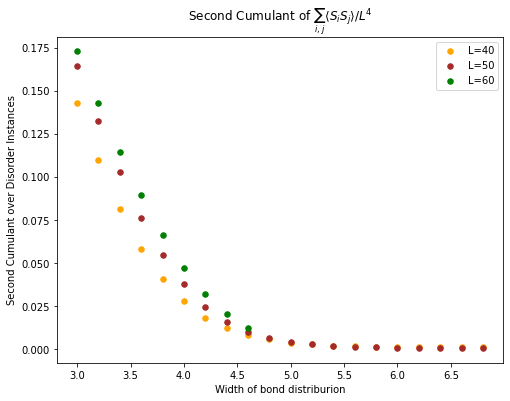

In [26]:
plt.figure(figsize=(8, 6))
for i, L in enumerate(L_list):
    plt.scatter(w_vals_comp[i], order_param_comp[i], c=c_dict[L], marker='o', label='L='+str(L), s=30)
    #plt.scatter(w_vals_comp[i], second_cum_comp[i], c=c_dict[L], marker='s', label='L='+str(L), s=30)
    #plt.scatter(w_vals_comp[i], fourth_cum_comp[i], c=c_dict[L], marker='^', label='L='+str(L), s=30)
    
plt.title(r"Second Cumulant of $\sum_{i,j}\langle S_iS_j\rangle / L^4$")
plt.xlabel("Width of bond distriburion")
plt.ylabel("Second Cumulant over Disorder Instances")
#plt.xlim(4.5, 5.5)
#plt.ylim(0, 0.1)
plt.legend()
#plt.savefig("Corr_mat_second_cum.png")